# Pop Song Classification

***
Author: Andre Layton
***

# Overview

In today's era, music consumption relies heavily on streaming services, with Spotify leading the way as one of the titans in the industry. Much of the appeal behind Spotify lies in its playlists and curated mixes. Consumers subscribe not only for the convenience, but also in Spotify's ability to introduce new music to their attention. This requires algorithms that can recommend tracks similar to, if not exactly to, the subscriber's preferences. For this reason, streaming companies have a need for optimal classification systems that can also allow for personalized recommendations. With pop being one of the most popular genres in the world, this project will analyze track information, including audio features, to create a model that will best classify pop tracks.

# Business Problem

Spotify executives are looking to improve their recommendation algorithms in order to gain more subscribers. The focus will be on pop songs, specifically, and this will require an algorithm to correctly identify tracks that are & are not pop. We'll be using Spotify data from the last 24 years (excluding 2024) in order to build a model that will accomplish this task. 

***
<img src="https://m.media-amazon.com/images/I/B112teWM7eL.png" style="height:550px" />

# Data Understanding

We'll start with importing all the necessary libraries first, as well as loading the dataset we'll be analyzing. The data, which was gathered from Kaggle, is Spotify data in CSV format that lists the top songs for every year from 2000-2023. We'll list the first 10 records for a preview of the data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report,\
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import svm
import joblib

In [2]:
# Load the dataset and list the first 15 records
spotify_df = pd.read_csv('data/Best Songs on Spotify from 2000-2023.csv', delimiter=';')
spotify_df.head(10)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
5,Daylight,David Kushner,gen z singer-songwriter,2023,130,43,51,-9,9,32,213,83,3,96
6,TQG,KAROL G,reggaeton,2023,180,63,72,-4,9,61,199,67,28,96
7,Calm Down (with Selena Gomez),Rema,afrobeats,2022,107,81,80,-5,11,80,239,38,4,95
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94
9,Here With Me,d4vd,bedroom pop,2022,132,47,57,-8,13,29,242,53,3,94


As shown above, there are 14 columns, each representing a feature of the track. We can see there is not only qualitative, but also quanitative data on each track, like audio features and popularity scores. To gain a better idea of the data, we'll continue with some additional exploratory methods. This will include a further look into our target column, which is the *top genre* feature. 

In [3]:
# Preview our target feature
spotify_df['top genre'].value_counts()

dance pop            460
pop                  250
atl hip hop           95
alternative metal     55
edm                   54
                    ... 
classical soul         1
filter house           1
dutch trance           1
future garage          1
deep euro house        1
Name: top genre, Length: 266, dtype: int64

We can see there is a wide variety of genres in our target feature. We can also see that there are many subgenres in the target column, which will complicate our modeling. Below we'll take a more statistical look.

In [4]:
# Print a statistical breakdown
spotify_df.describe()

,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
count,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000
mean,2011.116981,119.783648,69.792453,67.034801,-5.771488,17.787002,54.233962,225.946751,15.612998,10.112369,70.526625
std,6.748364,27.273075,16.164609,13.719049,2.072153,13.629287,22.458084,43.226704,20.277746,9.520815,11.419740
min,1985.000000,60.000000,6.000000,18.000000,-18.000000,2.000000,4.000000,115.000000,0.000000,2.000000,5.000000
25%,2005.000000,98.000000,59.000000,59.000000,-7.000000,9.000000,37.000000,200.000000,2.000000,4.000000,64.000000
50%,2011.000000,120.000000,71.000000,68.000000,-5.000000,12.000000,54.000000,221.000000,7.000000,6.000000,72.000000
75%,2017.000000,134.000000,82.000000,77.000000,-4.000000,23.000000,73.000000,246.000000,22.000000,12.000000,79.000000
max,2023.000000,211.000000,100.000000,98.000000,0.000000,84.000000,97.000000,688.000000,98.000000,58.000000,98.000000


In [5]:
# Display further information about the dataset
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          2385 non-null   object
 1   artist         2385 non-null   object
 2   top genre      2385 non-null   object
 3   year           2385 non-null   int64 
 4   bpm            2385 non-null   int64 
 5   energy         2385 non-null   int64 
 6   danceability   2385 non-null   int64 
 7   dB             2385 non-null   int64 
 8   liveness       2385 non-null   int64 
 9   valence        2385 non-null   int64 
 10  duration       2385 non-null   int64 
 11  acousticness   2385 non-null   int64 
 12  speechiness    2385 non-null   int64 
 13  popularity     2385 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 261.0+ KB


The initial statistical breakdown gives us an idea of how the numerical features in the dataset are scaled. In addition, we can see that none of these features are missing values, which makes our analysis easier. The next method confirms that fact, and gives us an additional summary about the Dataframe. Now that we've gained a look at the dataset, we'll begin transforming the data, specifically our target column. 

# Data Preparation

Let's begin by renaming the dataset, and then categorize all forms of pop into one genre for classification purposes. We can see this change made by previewing the first 10 records again. 

In [6]:
# Make a copy of the dataset
df2 = spotify_df.copy()

In [7]:
# Create a function that will replace every pop-based genre to 'pop'
def contains_pop(genre):
    word = "pop"
    if word in genre:
        return word
    else:
        return genre

# Use the new function to transform records
df2['top genre'] = df2['top genre'].map(lambda x: contains_pop(x))
df2['top genre'].value_counts()

pop                           1061
atl hip hop                     95
alternative metal               55
edm                             54
contemporary r&b                43
                              ... 
filter house                     1
new jersey underground rap       1
dark clubbing                    1
future garage                    1
deep euro house                  1
Name: top genre, Length: 205, dtype: int64

In [8]:
df2.head(10)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,pop,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
5,Daylight,David Kushner,gen z singer-songwriter,2023,130,43,51,-9,9,32,213,83,3,96
6,TQG,KAROL G,reggaeton,2023,180,63,72,-4,9,61,199,67,28,96
7,Calm Down (with Selena Gomez),Rema,afrobeats,2022,107,81,80,-5,11,80,239,38,4,95
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94
9,Here With Me,d4vd,pop,2022,132,47,57,-8,13,29,242,53,3,94


The next step is using the OneHotEncoder to replace our *top genre* column with a new *pop song* feature, that will identify whether the record falls under the pop genre or not. This will be vital for modeling. We'll also remove any blank space in the column names for easier processing. 

In [9]:
# Remove any blank space in the column names
df2.columns = df2.columns.str.replace(' ', '') 

# One hot encode the genres field between pop & not pop to create target column
ohe = OneHotEncoder()
col_to_encode = ['topgenre']
ohe.fit(df2[col_to_encode])
df2_encoded = ohe.transform(df2[col_to_encode])
df3 = pd.DataFrame(df2_encoded.todense(), columns=ohe.get_feature_names(), index=df2.index)
df3_without_pop = df3.drop('x0_pop', axis=1)

# Concatenate the new 'x0_pop' feature with the dataset
# Drop any unnecessary columns and rename the new feature to 'pop song'
df3_conc = pd.concat([df2, df3], axis=1).drop('topgenre', axis=1)
df3_conc.drop(df3_without_pop, axis=1, inplace=True)
df3_conc.rename(columns={'x0_pop' : 'pop song'}, inplace=True)
df3_conc.head(15)

,title,artist,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity,pop song
0,Flowers,Miley Cyrus,2023,118,68,71,-4,3,65,200,6,7,98,1.0
1,Cupid - Twin Ver.,FIFTY FIFTY,2023,120,59,78,-8,35,73,174,44,3,97,1.0
2,BESO,ROSALÍA,2023,95,64,77,-7,17,53,195,74,14,96,1.0
3,Boy's a liar Pt. 2,PinkPantheress,2023,133,81,70,-8,25,86,131,25,5,96,0.0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,2022,98,62,72,-6,8,17,222,42,5,96,0.0
5,Daylight,David Kushner,2023,130,43,51,-9,9,32,213,83,3,96,0.0
6,TQG,KAROL G,2023,180,63,72,-4,9,61,199,67,28,96,0.0
7,Calm Down (with Selena Gomez),Rema,2022,107,81,80,-5,11,80,239,38,4,95,0.0
8,Anti-Hero,Taylor Swift,2022,97,64,64,-7,14,53,201,13,5,94,1.0
9,Here With Me,d4vd,2022,132,47,57,-8,13,29,242,53,3,94,1.0


In [10]:
df3_conc.shape

(2385, 14)

We can see above that the columns were removed and concatenated, respectively. Note that the overall shape of the dataset remains intact, and now we can begin to look for any correlations between these features and our target variable. 

The correlation matrix method below gives us better insight into the relationships between the predictors and the target. We can see that speechiness has the strongest correlation with the *pop song* genre; and conversely, liveness being the weakest. The heatmap further below gives us a better look at these correlations.

In [11]:
# Create a correlation matrix
df3_conc.corr()

,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity,pop song
year,1.000000,0.037433,-0.213572,0.032387,-0.078104,-0.029241,-0.233264,-0.330849,0.159780,-0.023466,0.205909,0.088272
bpm,0.037433,1.000000,0.128883,-0.175970,0.071543,0.011156,-0.022143,-0.044491,-0.098704,0.066764,-0.019961,-0.028048
energy,-0.213572,0.128883,1.000000,-0.066279,0.678069,0.157227,0.365791,-0.048563,-0.523750,-0.007322,-0.120484,-0.057207
danceability,0.032387,-0.175970,-0.066279,1.000000,0.009636,-0.097046,0.379953,-0.103807,-0.098084,0.149590,-0.019491,0.071852
dB,-0.078104,0.071543,0.678069,0.009636,1.000000,0.089844,0.269899,-0.056888,-0.383500,-0.053500,-0.004715,0.022216
liveness,-0.029241,0.011156,0.157227,-0.097046,0.089844,1.000000,0.027507,0.015136,-0.102112,0.053680,-0.019009,0.003281
valence,-0.233264,-0.022143,0.365791,0.379953,0.269899,0.027507,1.000000,-0.120318,-0.185210,0.079725,-0.086720,0.067892
duration,-0.330849,-0.044491,-0.048563,-0.103807,-0.056888,0.015136,-0.120318,1.000000,-0.002133,0.039184,-0.095590,-0.020821
acousticness,0.159780,-0.098704,-0.523750,-0.098084,-0.383500,-0.102112,-0.185210,-0.002133,1.000000,-0.033682,0.100588,0.079264
speechiness,-0.023466,0.066764,-0.007322,0.149590,-0.053500,0.053680,0.079725,0.039184,-0.033682,1.000000,-0.072670,-0.119503


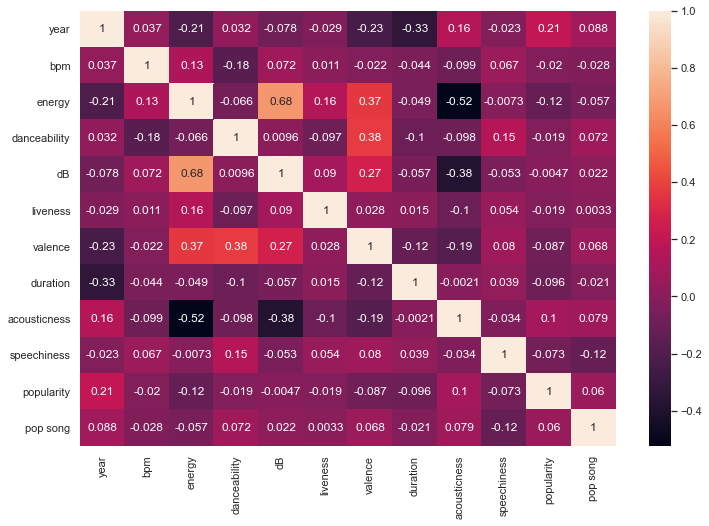

In [12]:
# Plot a heatmap with the Pearson coefficient values listed
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(df3_conc.corr(), annot=True);

# Modeling
## Baseline Model:
Now that we have an idea of what correlates best with our target variable, we can begin constructing classification models. Before creating our baseline model, let's drop the target column, along with some unnecessary features. We'll then split the data (using 24% as our test size), and use a MinMaxScaler transformer to scale our numerical data. 

In [13]:
# Drop remaining unnecessary features as well as the target variable
cols_to_drop = ['artist', 'title', 'year', 'pop song']

# Split the data into training and test sets
y = df3_conc['pop song']
df3_conc = df3_conc.drop(cols_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(df3_conc, y, test_size=.24, random_state=17)

# Print the training data's shape
X_train.shape

(1812, 10)

You can see the dataset's shape remains intact after transformation (note the shape property above and below).

In [14]:
# Use the StandardScaler function to scale the data
cols = X_train.columns

scaler = MinMaxScaler()
X_train_processed = scaler.fit_transform(X_train)
X_test_processed = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_processed, columns = cols)
X_test = pd.DataFrame(X_test_processed, columns = cols)

# Check & reconfirm the training data's shape
X_train_processed.shape

(1812, 10)

The first model we'll use as our baseline will be a Decision Tree classifier. We'll start with a max depth of 4, and predict some estimates to later calculate both the accuracy and precision scores for the training and testing datasets.

In [15]:
# Create a baseline model - a Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X_train, y_train)

# Predict estimates for both training & test sets
y_train_hat = tree_clf.predict(X_train)
y_test_hat = tree_clf.predict(X_test)

# Print the accuracy and precision scores for both sets of data
print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))
print('')
print("Training Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_train, y_train_hat) * 100))
print("Testing Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_test, y_test_hat) * 100))

Training Accuracy for Decision Tree Classifier: 64.13%
Testing Accuracy for Decision Tree Classifier: 55.85%

Training Precision for Decision Tree Classifier: 59.34%
Testing Precision for Decision Tree Classifier: 47.95%


As we can see, this model is not very good; however, it is only the baseline. The accuracy and precision scores of the test set (56% and 48%, respectively) are low, but also not terribly far from the respective training set scores - which suggests the model is not overfitting the data. 

The classification report further demonstrates these observations; however, the confusion matrix visual gives us a better idea of how effective the classifier is. 

In [16]:
# Print the classification report
print(f'Decision Tree: \n {classification_report(y_test, y_test_hat)}')

Decision Tree: 
               precision    recall  f1-score   support

         0.0       0.66      0.50      0.57       333
         1.0       0.48      0.63      0.55       240

    accuracy                           0.56       573
   macro avg       0.57      0.57      0.56       573
weighted avg       0.58      0.56      0.56       573



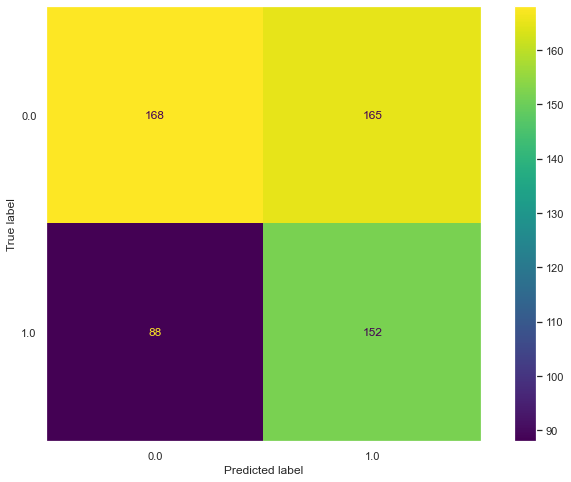

In [17]:
# Plot the confusion matrix 
cm = confusion_matrix(y_test, y_test_hat, labels=tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

In order to make classification more effective, we'll need to improve on our precision going forward. This will require us to reduce our false positive rate, while also remaining cautious of overfitting the data. 

The ROC AUC score below also gives us an idea of how effective of a model the Decision Tree is. The score below - approximately .569 - will be our baseline to compare future models to.

In [18]:
# Compute the ROC AUC score
roc_auc_score(y_test, y_test_hat)

0.5689189189189189

We'll also create a list of feature rankings to get an idea of what predictors have significant influence in the model above. We'll sort the dictionary in descending order, then plot these importances for a better look.

In [19]:
# Generate a sorted dictionary listing the feature importances
feature_rankings = {}
for fi, feature in sorted(zip(tree_clf.feature_importances_, X_train.columns), reverse=True):
    feature_rankings[feature] = fi
print(feature_rankings)

{'duration': 0.27028939412195774, 'speechiness': 0.17394496116449026, 'danceability': 0.1639431676729791, 'acousticness': 0.16200289590577238, 'liveness': 0.06640265182838946, 'bpm': 0.051458366671975835, 'valence': 0.04346483024938241, 'popularity': 0.03658940914313678, 'dB': 0.03190432324191608, 'energy': 0.0}


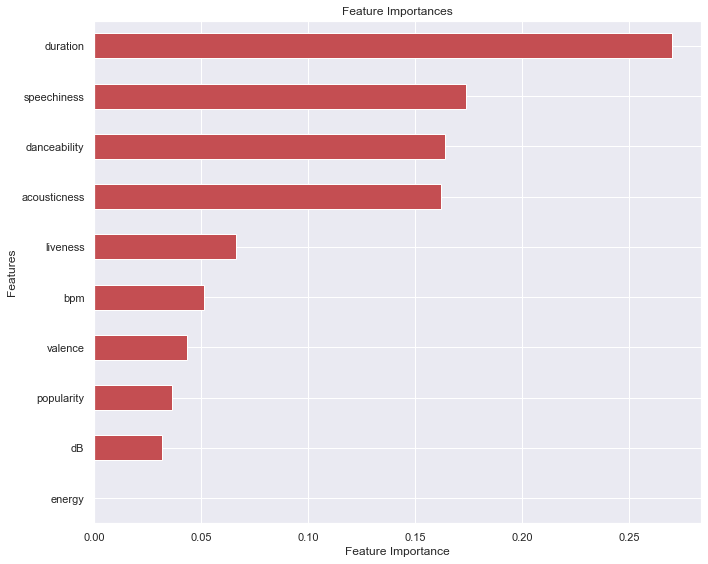

In [20]:
# Visualize the feature importances
importances = tree_clf.feature_importances_
important_features = pd.Series(importances, index=X_train.columns)


fig, ax = plt.subplots(figsize=(10, 8))
important_features.nsmallest(10).plot(kind='barh', color='r')
ax.set_title("Feature Importances")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
fig.tight_layout()

The bar graph shows us that duration, speechiness, danceability, and acousticness have the most impact on the target in the baseline Decision Tree model. This also reflects, in a way, what the correlation matrix displayed earlier - where, danceability, speechiness, and acousticness were among the features that correlated with our target best. 

However, the Decision Tree model needs to be tuned to improve on its precision score. We'll create a parameter grid with a range of hyperparameter options for a grid search. We'll also cross-validate the model 5 times, and return the training score.

In [21]:
# Create a parameter grid
dt_param_grid = {'criterion': ['gini', 'entropy'], 
                'max_depth': [None, 3, 4, 5, 6, 7, 8],
                'min_samples_split': [10, 20, 25, 40, 50, 80, 100], 
                'min_samples_leaf': [5, 10, 25, 50, 75, 100]}

In [22]:
# Instantiate & fit a Decision Tree classifier
dt_clf = DecisionTreeClassifier()

# Conduct a grid search & fit the object
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=5, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [5, 10, 25, 50, 75, 100],
                         'min_samples_split': [10, 20, 25, 40, 50, 80, 100]},
             return_train_score=True)

Now we can find the best combination of hyperparameters, as well as calculate the average training score and the testing score. 

In [23]:
# Print the "optimal" hyperparameter combination
print(f'Best Parameter Combination Found During Grid Search: \n{dt_grid_search.best_params_}')

Best Parameter Combination Found During Grid Search: 
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 80}


In [24]:
# Calculate the mean train score
print(np.mean(dt_grid_search.cv_results_['mean_train_score']))

0.6440430398665261


In [25]:
# Calculate the testing score
dt_grid_search.score(X_test, y_test)

0.5602094240837696

As we can see, the accuracy improved for both sets of data! Therefore, we should see a similar improvement in our model in both accuracy and precision.

In [26]:
# Instantiate & fit the Decision Tree model with the "optimal" hyperparameters
optimal_dt = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5, min_samples_split=80)
optimal_dt.fit(X_train, y_train)

# Predict estimates
y_train_hat = optimal_dt.predict(X_train)
y_test_hat = optimal_dt.predict(X_test)

# Print accuracy and precision scores
print("Training Accuracy for Tuned Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Testing Accuracy for Tuned Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))
print('')
print("Training Precision for Tuned Decision Tree Classifier: {:.4}%".format(precision_score(y_train, y_train_hat) * 100))
print("Testing Precision for Tuned Decision Tree Classifier: {:.4}%".format(precision_score(y_test, y_test_hat) * 100))

Training Accuracy for Tuned Decision Tree Classifier: 65.56%
Testing Accuracy for Tuned Decision Tree Classifier: 56.02%

Training Precision for Tuned Decision Tree Classifier: 60.91%
Testing Precision for Tuned Decision Tree Classifier: 48.06%


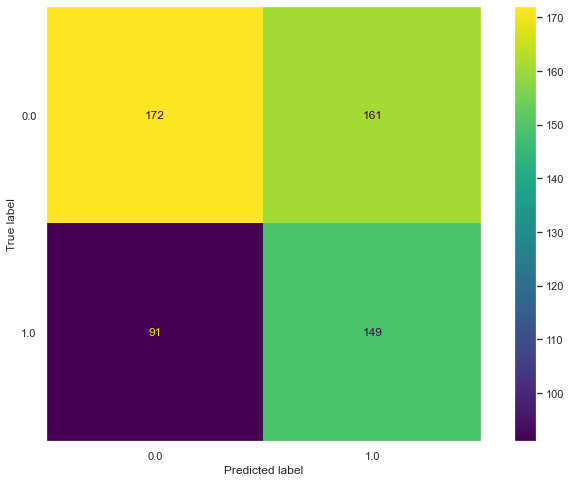

In [27]:
# Plot the confusion matrix 
cm = confusion_matrix(y_test, y_test_hat, labels=optimal_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=optimal_dt.classes_)
disp.plot()
plt.grid(False)
plt.show();

Although our model improved, it wasn't enough to call this a good model. The test set's precision score still falls under 49%, which is worse than random chance. The false positives reduced slightly, which led to the slight increase in the test set's precision, but it's still ineffective.

## Further Modeling:

Now we've established our baseline model with the best possible combination of parameters. However, this is just the standard for comparison - and to be frank, improvement. We'll construct another model using ensemble methods - specifically, the Random Forests method. First we'll create a Random Forests model with a few hyperparameters before potentially tuning for an "optimal" version. We'll calculate the scores first, then display the precision scores for both datasets.

In [28]:
# Create a Random Forests model & evaluate both sets' accuracies
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.7058498896247241
0.6090750436300174


In [29]:
# Predict estimates for both sets of data
y_train_hat = forest.predict(X_train)
y_test_hat = forest.predict(X_test)

# Print precision scores
print("Training Precision for Random Forest Classifier: {:.4}%".format(precision_score(y_train, y_train_hat) * 100))
print("Testing Precision for Random Forest Classifier: {:.4}%".format(precision_score(y_test, y_test_hat) * 100))

Training Precision for Random Forest Classifier: 70.99%
Testing Precision for Random Forest Classifier: 53.54%


Now we've finally crossed the 50% mark! Although, the training precision score is getting farther from the test set's score, which implies some overfitting. Tuning this model may improve the scores better than tuning the decision tree. We'll conduct another combinatoric grid search, but first calculate the average validation score.

In [30]:
# Instantiate another Random Forests classifier
rf_clf = RandomForestClassifier()

# Calculate & print the average validation score
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train,
                                          y_train, cv=5))
print(mean_rf_cv_score)

0.6225195196566368


We create the parameter grid to a few parameter ranges, and instantiate the grid search tool before fitting it to the training data. Afterwards, we'll display the test score, and the best combination of hyperparameters for our random forest model.

In [31]:
# Create a parameter grid for a grid search
rf_param_grid = {'n_estimators': [30, 50, 100, 125],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 4, 6, 8, 10],
                'min_samples_split': [5, 10, 15], 
                'min_samples_leaf': [5, 10, 15]}

# Instantiate the GridSearchCV object
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)

In [32]:
# Fit the grid search object
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 6, 8, 10],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [30, 50, 100, 125]})

In [33]:
# Print the testing set's accuracy & the "optimal" parameters
print(f'Testing Accuracy: {rf_grid_search.best_score_: .2%}')
print('')
print(f'Optimal Parameters: \n{rf_grid_search.best_params_}')

Testing Accuracy:  62.91%

Optimal Parameters: 
{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 125}


Now that we have our "optimal" parameters, lets create & fit another random forest model with these parameters in place. We'll predict some estimates in order to calculate the training and testing accuracy and precision scores, then compute the ROC AUC score to evaluate the model.

In [34]:
# Create another Random Forests model with tuned hyperparameters
forest_2 = RandomForestClassifier(n_estimators=125, criterion='gini', max_depth=8, 
                                  min_samples_leaf=5, min_samples_split=5)
forest_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=125)

In [35]:
# Predict estimates
y_train_hat = forest_2.predict(X_train)
y_test_hat = forest_2.predict(X_test)

# Print accuracy and precision scores
print("Training Accuracy for Tuned Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Testing Accuracy for Tuned Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))
print('')
print("Training Precision for Tuned Random Forest Classifier: {:.4}%".format(precision_score(y_train, y_train_hat) * 100))
print("Testing Precision for Tuned Random Forest Classifier: {:.4}%".format(precision_score(y_test, y_test_hat) * 100))

Training Accuracy for Tuned Random Forest Classifier: 80.63%
Testing Accuracy for Tuned Random Forest Classifier: 60.73%

Training Precision for Tuned Random Forest Classifier: 81.33%
Testing Precision for Tuned Random Forest Classifier: 53.3%


In [36]:
# Compute the ROC AUC score
roc_auc_score(y_test, y_test_hat)

0.5929241741741742

The tuned Random Forest model actually improved our model further; however, that's still not saying much considering the testing precision score still falls below 54%. The gap between both sets of scores is also getting bigger, which confirms that our model is overfitting the training data. Although the ensemble methods improved our precision, it is at the cost of high variance. 

The confusion matrix below shows how our precision is improving, with the false positive count decreasing after creating and tuning our Random Forest model. 

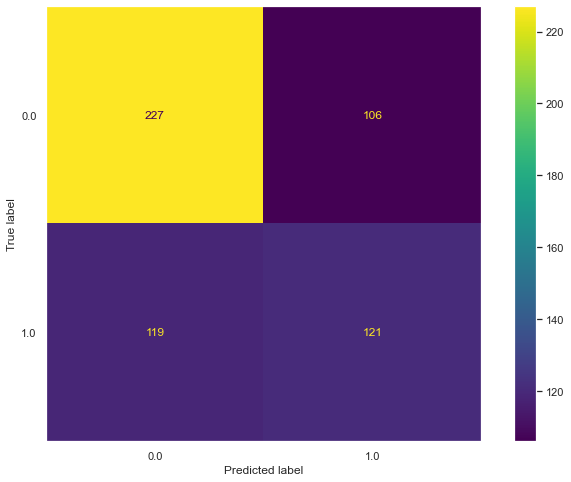

In [37]:
# Plot the confusion matrix 
cm = confusion_matrix(y_test, y_test_hat, labels=forest_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=forest_2.classes_)
disp.plot()
plt.grid(False)
plt.show();

Lets see how our features importances have changed after applying a Random Forests model. 

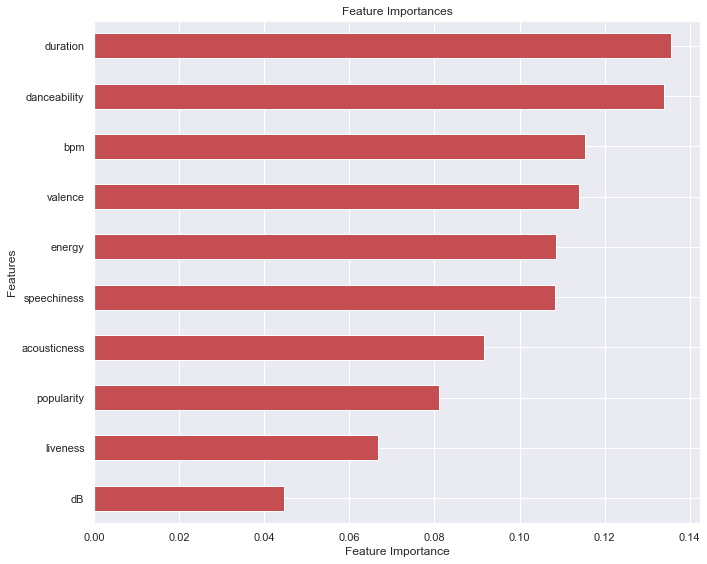

In [38]:
# Visualize the feature importances
importances = forest_2.feature_importances_
important_features = pd.Series(importances, index=X_train.columns)


fig, ax = plt.subplots(figsize=(10, 8))
important_features.nsmallest(10).plot(kind='barh', color='r')
ax.set_title("Feature Importances")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
fig.tight_layout()

The plot above is quite different from our earlier visual, in that every predictor has 

## Final Model:

We'll be using Support Vector Machines (SVM)

In [39]:
# Create a Gradient Boosting classifier model 
gbt_clf = GradientBoostingClassifier(random_state=17)
gbt_clf.fit(X_train, y_train)

# Predict estimates
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [40]:
# Print accuracy and precision scores
print("Training Accuracy for Gradient Boosted Classifier: {:.4}%".format(accuracy_score(y_train, gbt_clf_train_preds) * 100))
print("Testing Accuracy for Gradient Boosted Classifier: {:.4}%".format(accuracy_score(y_test, gbt_clf_test_preds) * 100))
print('')
print("Training Precision for Gradient Boosted Classifier: {:.4}%".format(precision_score(y_train, gbt_clf_train_preds) * 100))
print("Testing Precision for Gradient Boosted Classifier: {:.4}%".format(precision_score(y_test, gbt_clf_test_preds) * 100))

Training Accuracy for Gradient Boosted Classifier: 74.83%
Testing Accuracy for Gradient Boosted Classifier: 60.91%

Training Precision for Gradient Boosted Classifier: 73.43%
Testing Precision for Gradient Boosted Classifier: 53.28%


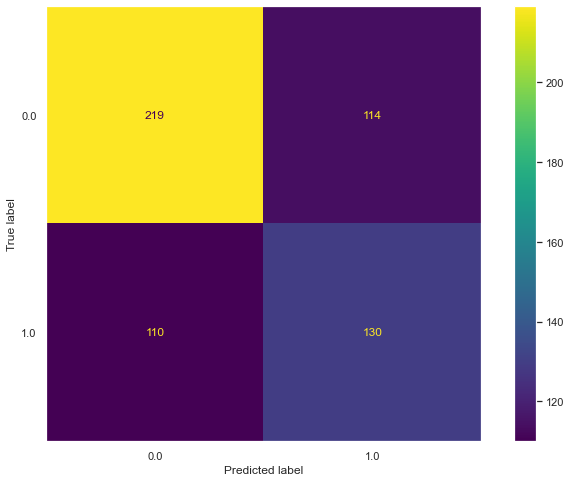

In [41]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, gbt_clf_test_preds, labels=gbt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gbt_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

In [42]:
# Print the mean validation score
print(cross_val_score(gbt_clf, df3_conc, y=y, cv=5).mean())

0.5463312368972746


In [43]:
# Instantiate the SVM function
svm_clf = svm.SVC()

# Fit the object to our processed training data and labels
svm_clf.fit(X_train_processed, y_train)

SVC()

In [44]:
# Print the accuracy scores for both sets of data
print(svm_clf.score(X_train_processed, y_train))
print(svm_clf.score(X_test_processed, y_test))

0.6330022075055187
0.62478184991274


In [45]:
# Predict estimates
y_train_hat = svm_clf.predict(X_train_processed)
y_test_hat = svm_clf.predict(X_test_processed)

# Print the precision scores for both datasets
print("Training Precision for SVM: {:.4}%".format(precision_score(y_train, y_train_hat) * 100))
print("Testing Precision for SVM: {:.4}%".format(precision_score(y_test, y_test_hat) * 100))

Training Precision for SVM: 62.26%
Testing Precision for SVM: 55.56%


In [46]:
# Compute the ROC AUC score
roc_auc_score(y_test, y_test_hat)

0.6102665165165165

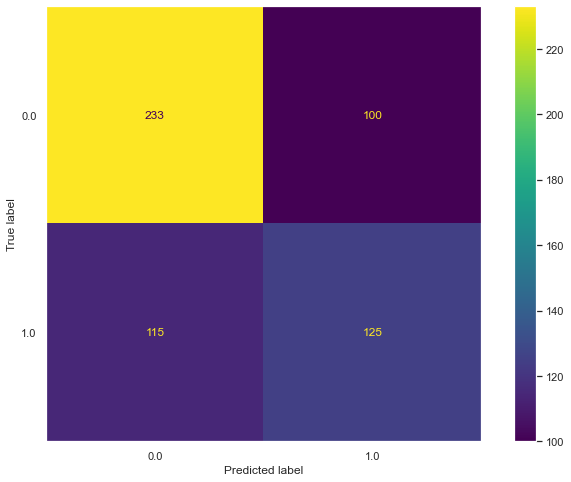

In [47]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_hat, labels=svm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

# Deployment

In [48]:
with open('svm_model.pkl', 'wb') as f:
    joblib.dump(svm_clf, f)

# Conclusion

# Limitations & Further Work